### ESM-4: toy optimization problem.
- two generators, single load, single bus
- multiple time periods
- a storage device
- a discussion of storage dispatch, and the impact on the system
- (start of) a discussion about model VS reality juxtaposition

In [165]:
### Problem formulation
# generator 1: "gas" (CCGT), marginal cost 70 EUR/MWh, capacity 50 MW
# generator 2: "coal" (hard coal), marginal cost 40 EUR/MWh, capacity 100 MW
# load: "UA" (Ukraine), 120 MW
# multiple time steps
# storage device: "battery", capacity 100 MWh, charging efficiency 0.9, discharging efficiency 0.9

In [166]:
import pypsa
import numpy as np
import pandas as pd
import linopy
import matplotlib.pyplot as plt

### Create PyPSA network with components of the problem

In [167]:
n = pypsa.Network()

In [168]:
n.add("Bus", "UA", v_nom=380)
n.add(
    "Generator",
    "gas",
    bus="UA",
    p_nom_extendable=False,
    marginal_cost=70,  # €/MWh
    p_nom=50,  # MW
)
n.add(
    "Generator",
    "coal",
    bus="UA",
    p_nom_extendable=False,
    marginal_cost=40,  # €/MWh
    p_nom=70,  # MW
)

In [169]:
n.snapshots = pd.date_range("2019-01-01", periods=5, freq="H")
load_series = pd.Series([30, 60, 80, 100, 70], index=n.snapshots)

In [170]:
n.add(
    "Load",
    "Ukraine",
    bus="UA",
    p_set=load_series,  # MW
)

In [171]:
n.loads_t.p_set

Load,Ukraine
snapshot,
2019-01-01 00:00:00,30.0
2019-01-01 01:00:00,60.0
2019-01-01 02:00:00,80.0
2019-01-01 03:00:00,100.0
2019-01-01 04:00:00,70.0


## Solve with PyPSA optimize module w/o storage

In [172]:
# n.optimize.create_model()

In [173]:
n.optimize(solver_name="glpk")

/home/iegor/miniconda3/envs/pypsa/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/iegor/miniconda3/envs/pypsa/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/iegor/miniconda3/envs/pypsa/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names t

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp /tmp/linopy-problem-4_lrwm5y.lp --output /tmp/linopy-solve-x9tt6caz.sol
Reading problem data from '/tmp/linopy-problem-4_lrwm5y.lp'...
25 rows, 10 columns, 30 non-zeros
135 lines were read
GLPK Simplex Optimizer 5.0
25 rows, 10 columns, 30 non-zeros
Preprocessing...
~     0: obj =   1.480000000e+04  infeas =  0.000e+00
OPTIMAL SOLUTION FOUND BY LP PREPROCESSOR
Time used:   0.0 secs
Memory used: 0.0 Mb (39693 bytes)
Writing basic solution to '/tmp/linopy-solve-x9tt6caz.sol'...


('ok', 'optimal')

In [174]:
n.objective

14800.0

In [175]:
n.generators_t.p

Generator,gas,coal
snapshot,,
2019-01-01 00:00:00,0.0,30.0
2019-01-01 01:00:00,0.0,60.0
2019-01-01 02:00:00,10.0,70.0
2019-01-01 03:00:00,30.0,70.0
2019-01-01 04:00:00,0.0,70.0


In [161]:
# def plot_dispatch(n):
#     df = n.generators_t.p
#     colors = {"coal": "#8B4513", "gas": "#FFA500"}
#     df = df[["coal", "gas"]]
#     df.plot(kind="bar", stacked=True, width=0.9, color=[colors[c] for c in df.columns])
#     plt.xticks(np.arange(len(df.index)), df.index.strftime("%H:%M"))
#     plt.xticks(rotation=0)
#     plt.xlabel("Time")
#     plt.ylabel("MW")
#     plt.legend(loc="upper left")
#     plt.show()


# plot_dispatch(n)

### Retrieve electricity prices w/o storage

In [176]:
n.model.dual

<xarray.Dataset>
Dimensions:                (snapshot: 5, Generator-fix: 2, Bus: 1)
Coordinates:
  * snapshot               (snapshot) datetime64[ns] 2019-01-01 ... 2019-01-0...
  * Generator-fix          (Generator-fix) object 'gas' 'coal'
  * Bus                    (Bus) object 'UA'
Data variables:
    Generator-fix-p-lower  (snapshot, Generator-fix) float64 30.0 0.0 ... 0.0
    Generator-fix-p-upper  (snapshot, Generator-fix) float64 0.0 0.0 ... 0.0 0.0
    Bus-nodal_balance      (snapshot, Bus) float64 40.0 40.0 70.0 70.0 40.0

<Axes: xlabel='snapshot'>

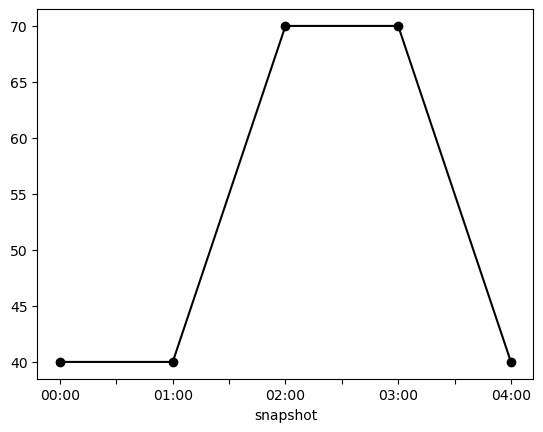

In [177]:
prices = n.model.dual["Bus-nodal_balance"].values
series = pd.Series([item[0] for item in prices], index=n.snapshots.strftime("%H:%M"))
series.plot(marker="o", linestyle="-", color="black")

## Solve with PyPSA optimize module with storage device

### Add battery storage

In [178]:
# see documentation: https://pypsa.readthedocs.io/en/latest/components.html#storage-unit

n.add(
    "StorageUnit",
    "Battery",
    bus="UA",
    p_nom_extendable=False,
    p_nom=20,  # MW
    max_hours=5,  # 20 MW * 5 hours = 100 MWh
    efficiency_store=0.9,
    efficiency_dispatch=0.9,
    state_of_charge_initial=0  # MWh
    # cyclic_state_of_charge=True,
)

In [ ]:
# n.storage_units.T

### Solve the problem with storage and revise results

In [ ]:
# See documentation of storage unit equations: https://pypsa.readthedocs.io/en/latest/optimal_power_flow.html#storage-unit-constraints
# ensure that the new variables and equations are added to the model
# n.optimize.create_model()

In [179]:
n.optimize(solver_name="glpk")

/home/iegor/miniconda3/envs/pypsa/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/iegor/miniconda3/envs/pypsa/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/iegor/miniconda3/envs/pypsa/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names t

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp /tmp/linopy-problem-w3dfkirl.lp --output /tmp/linopy-solve-or9fa9vu.sol
Reading problem data from '/tmp/linopy-problem-w3dfkirl.lp'...
60 rows, 25 columns, 89 non-zeros
307 lines were read
GLPK Simplex Optimizer 5.0
60 rows, 25 columns, 89 non-zeros
Preprocessing...
10 rows, 19 columns, 33 non-zeros
Scaling...
 A: min|aij| =  9.000e-01  max|aij| =  1.111e+00  ratio =  1.235e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 10
      0: obj =   2.380000000e+04 inf =   1.100e+02 (4)
      5: obj =   2.050000000e+04 inf =   0.000e+00 (0)
*    16: obj =   1.429900000e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.1 Mb (56572 bytes)
Writing basic solution to '/tmp/linopy-solve-or9fa9vu.sol'...


('ok', 'optimal')

In [180]:
# Objective w/o storage unit 15600.0
n.objective

14299.0

### Prepare dashboard

In [194]:
def dashboard(n):
    def plot_balance(n, ax):
        balance = (
            n.statistics.energy_balance(aggregate_time=False, aggregate_bus=False)
            .loc[:, :, "AC", "UA"]
            .droplevel(1)
        )
        colors = {"Load": "grey", "Generator": "blue", "StorageUnit": "black"}
        balance.T.plot(
            kind="bar",
            stacked=True,
            width=0.9,
            color=[colors[c] for c in balance.index],
            ax=ax,
        )
        ax.set_xticks(np.arange(len(balance.columns)))
        ax.set_xticklabels(balance.columns.strftime("%H:%M"), rotation=0)
        ax.set_ylabel("MW")
        ax.legend(loc="upper left")
        ax.set_title("Energy Balance")

    # Assuming 'n' is your data object that contains all the necessary information

    # Create a 2x2 subplot grid
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    # Plot 1: Energy Balance
    plot_balance(n, axs[0, 0])

    # Plot 2: Storage Unit Dispatch
    dispatch_time = n.storage_units_t.p.index.strftime("%H:%M")
    axs[0, 1].plot(
        dispatch_time,
        n.storage_units_t.p.values,
        marker="o",
        linestyle="-",
        color="black",
    )
    axs[0, 1].set_ylabel("MW")
    axs[0, 1].set_title("Storage Dispatch")

    # Plot 3: Storage Unit State of Charge
    state_of_charge_time = n.storage_units_t.state_of_charge.index.strftime("%H:%M")
    axs[1, 0].plot(
        state_of_charge_time,
        n.storage_units_t.state_of_charge.values,
        marker="o",
        linestyle="-",
        color="black",
    )
    axs[1, 0].set_ylabel("MWh")
    axs[1, 0].set_title("Storage State of Charge")

    # Plot 4: Prices
    prices = n.model.dual["Bus-nodal_balance"].values
    series = pd.Series(
        [item[0] for item in prices], index=n.snapshots.strftime("%H:%M")
    )
    axs[1, 1].plot(
        series.index, series.values, marker="o", linestyle="-", color="black"
    )
    axs[1, 1].set_title("Electricity price estimate")
    axs[1, 1].set_ylabel("€/MWh")

    # Adjust layout
    plt.tight_layout()
    plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

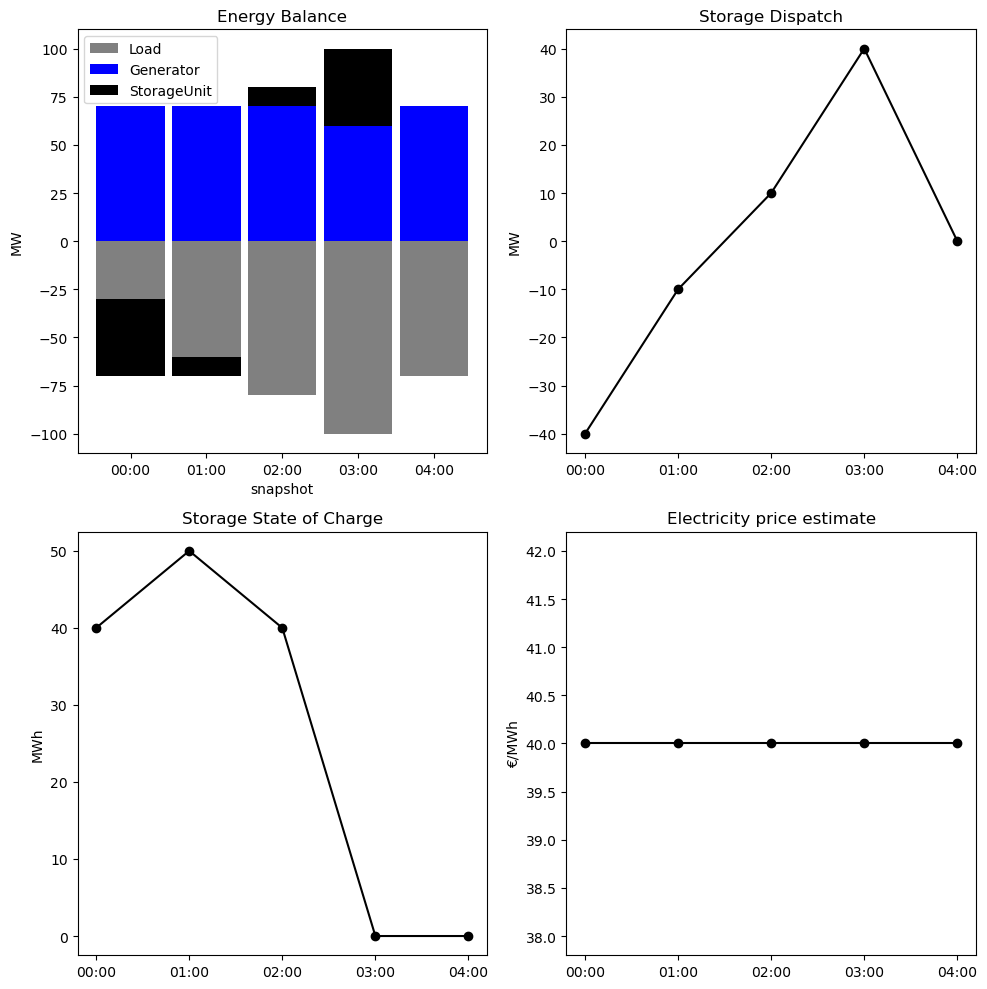

In [195]:
dashboard(n)

## Changing staff and seeing what happens

### Scenario: unlimited storage, no losses

In [185]:
if len(n.storage_units) != 0:
    n.remove("StorageUnit", "Battery")

In [186]:
n.add(
    "StorageUnit",
    "Battery",
    bus="UA",
    p_nom_extendable=False,
    p_nom=100,  # MW
    max_hours=10,  # 100 MW * 10 hours = 1000 MWh
    efficiency_store=1,  # n0 losses
    efficiency_dispatch=1,  # no losses
    state_of_charge_initial=0  # MWh
    # cyclic_state_of_charge=True,
)

/home/iegor/miniconda3/envs/pypsa/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/iegor/miniconda3/envs/pypsa/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/iegor/miniconda3/envs/pypsa/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names t

Set parameter TokenServer to value "ensys3.service.tu-berlin.de"


INFO:gurobipy:Set parameter TokenServer to value "ensys3.service.tu-berlin.de"
INFO:linopy.io: Writing time: 0.03s


Read LP format model from file /tmp/linopy-problem-q7tmauor.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-q7tmauor.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 60 rows, 25 columns, 89 nonzeros


INFO:gurobipy:obj: 60 rows, 25 columns, 89 nonzeros


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)


INFO:gurobipy:Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)


INFO:gurobipy:


CPU model: AMD Ryzen 7 PRO 5850U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 PRO 5850U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 60 rows, 25 columns and 89 nonzeros


INFO:gurobipy:Optimize a model with 60 rows, 25 columns and 89 nonzeros


Model fingerprint: 0x6f544940


INFO:gurobipy:Model fingerprint: 0x6f544940


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e+01, 7e+01]


INFO:gurobipy:  Objective range  [4e+01, 7e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [3e+01, 1e+03]


INFO:gurobipy:  RHS range        [3e+01, 1e+03]


Presolve removed 55 rows and 11 columns


INFO:gurobipy:Presolve removed 55 rows and 11 columns


Presolve time: 0.00s


INFO:gurobipy:Presolve time: 0.00s


Presolved: 5 rows, 14 columns, 18 nonzeros


INFO:gurobipy:Presolved: 5 rows, 14 columns, 18 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    0.0000000e+00   4.625000e+01   0.000000e+00      0s


INFO:gurobipy:       0    0.0000000e+00   4.625000e+01   0.000000e+00      0s


       6    1.3600000e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    1.3600000e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.01 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.01 seconds (0.00 work units)


Optimal objective  1.360000000e+04


INFO:gurobipy:Optimal objective  1.360000000e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 25 primals, 60 duals
Objective: 1.36e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, ca

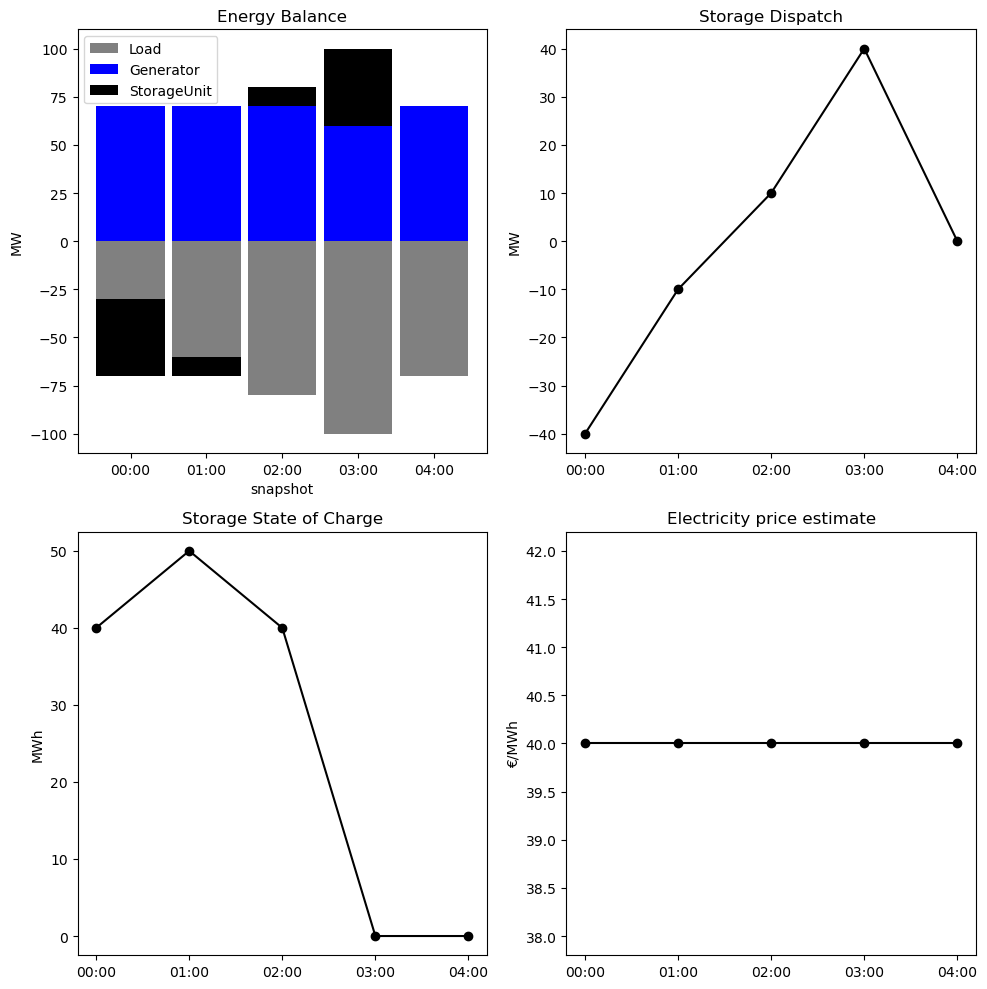

In [187]:
n.optimize(solver_name="gurobi")
dashboard(n)

In [123]:
n.objective

14700.0

### Scenario: 10 MW power x 10h duration storage, no losses

In [196]:
if len(n.storage_units) != 0:
    n.remove("StorageUnit", "Battery")

In [197]:
n.add(
    "StorageUnit",
    "Battery",
    bus="UA",
    p_nom_extendable=False,
    p_nom=10,  # MW
    max_hours=10,  # 100 MW * 10 hours = 1000 MWh
    efficiency_store=1,  # n0 losses
    efficiency_dispatch=1,  # no losses
    state_of_charge_initial=0  # MWh
    # cyclic_state_of_charge=True,
)

/home/iegor/miniconda3/envs/pypsa/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/iegor/miniconda3/envs/pypsa/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/iegor/miniconda3/envs/pypsa/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names t

Set parameter TokenServer to value "ensys3.service.tu-berlin.de"


INFO:gurobipy:Set parameter TokenServer to value "ensys3.service.tu-berlin.de"
INFO:linopy.io: Writing time: 0.03s


Read LP format model from file /tmp/linopy-problem-3asn3ger.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-3asn3ger.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 60 rows, 25 columns, 89 nonzeros


INFO:gurobipy:obj: 60 rows, 25 columns, 89 nonzeros


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)


INFO:gurobipy:Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)


INFO:gurobipy:


CPU model: AMD Ryzen 7 PRO 5850U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 PRO 5850U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 60 rows, 25 columns and 89 nonzeros


INFO:gurobipy:Optimize a model with 60 rows, 25 columns and 89 nonzeros


Model fingerprint: 0xadd5cdd3


INFO:gurobipy:Model fingerprint: 0xadd5cdd3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e+01, 7e+01]


INFO:gurobipy:  Objective range  [4e+01, 7e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+01, 1e+02]


INFO:gurobipy:  RHS range        [1e+01, 1e+02]


Presolve removed 55 rows and 15 columns


INFO:gurobipy:Presolve removed 55 rows and 15 columns


Presolve time: 0.00s


INFO:gurobipy:Presolve time: 0.00s


Presolved: 5 rows, 10 columns, 14 nonzeros


INFO:gurobipy:Presolved: 5 rows, 10 columns, 14 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.0999560e+04   1.625275e+01   0.000000e+00      0s


INFO:gurobipy:       0    1.0999560e+04   1.625275e+01   0.000000e+00      0s


       5    1.4200000e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    1.4200000e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.01 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.01 seconds (0.00 work units)


Optimal objective  1.420000000e+04


INFO:gurobipy:Optimal objective  1.420000000e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 25 primals, 60 duals
Objective: 1.42e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, ca

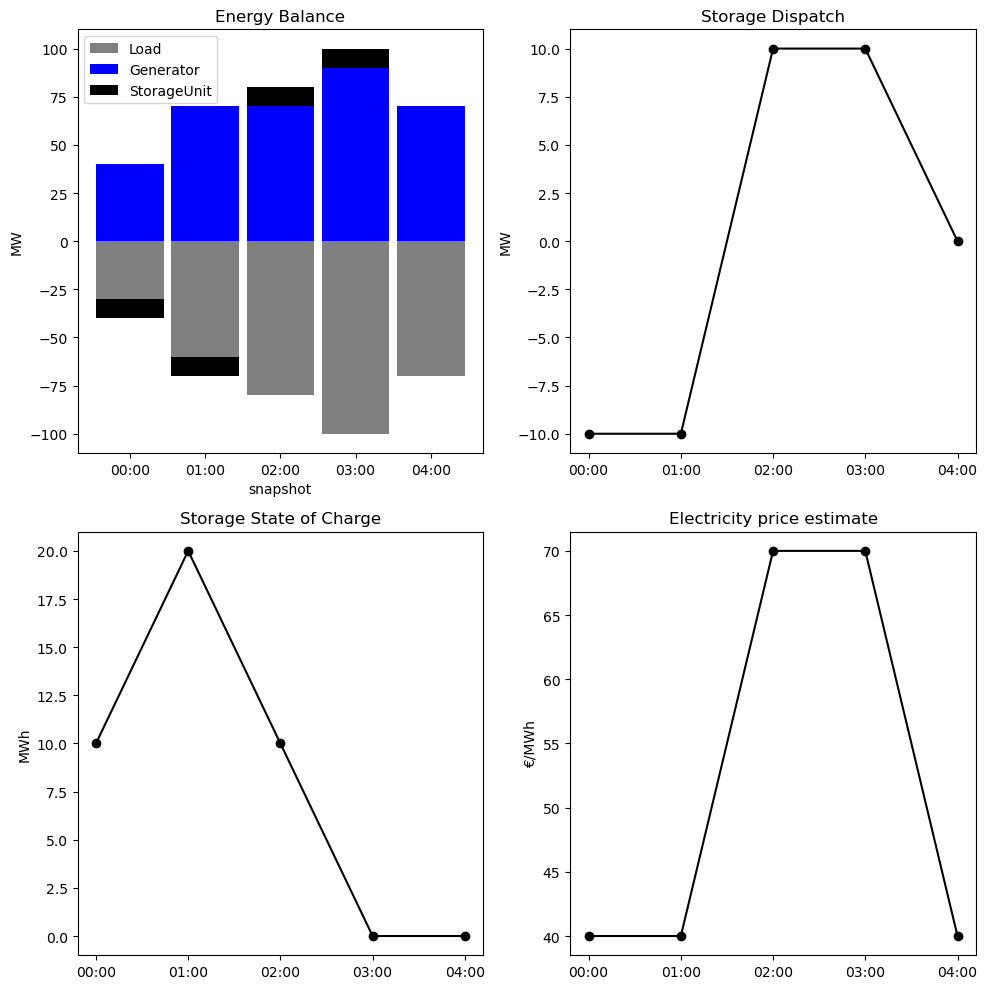

In [198]:
n.optimize(solver_name="gurobi")
dashboard(n)

### Scenario: 10 MW power x 1h duration storage, no losses

In [206]:
if len(n.storage_units) != 0:
    n.remove("StorageUnit", "Battery")

In [207]:
n.add(
    "StorageUnit",
    "Battery",
    bus="UA",
    p_nom_extendable=False,
    p_nom=10,  # MW
    max_hours=1,  # 100 MW * 10 hours = 1000 MWh
    efficiency_store=1,  # n0 losses
    efficiency_dispatch=1,  # no losses
    state_of_charge_initial=0  # MWh
    # cyclic_state_of_charge=True,
)

/home/iegor/miniconda3/envs/pypsa/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/iegor/miniconda3/envs/pypsa/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/iegor/miniconda3/envs/pypsa/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names t

Set parameter TokenServer to value "ensys3.service.tu-berlin.de"


INFO:gurobipy:Set parameter TokenServer to value "ensys3.service.tu-berlin.de"
INFO:linopy.io: Writing time: 0.03s


Read LP format model from file /tmp/linopy-problem-eywwhy14.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-eywwhy14.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 60 rows, 25 columns, 89 nonzeros


INFO:gurobipy:obj: 60 rows, 25 columns, 89 nonzeros


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)


INFO:gurobipy:Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)


INFO:gurobipy:


CPU model: AMD Ryzen 7 PRO 5850U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 PRO 5850U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 60 rows, 25 columns and 89 nonzeros


INFO:gurobipy:Optimize a model with 60 rows, 25 columns and 89 nonzeros


Model fingerprint: 0x682913bb


INFO:gurobipy:Model fingerprint: 0x682913bb


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e+01, 7e+01]


INFO:gurobipy:  Objective range  [4e+01, 7e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+01, 1e+02]


INFO:gurobipy:  RHS range        [1e+01, 1e+02]


Presolve removed 60 rows and 25 columns


INFO:gurobipy:Presolve removed 60 rows and 25 columns


Presolve time: 0.00s


INFO:gurobipy:Presolve time: 0.00s


Presolve: All rows and columns removed


INFO:gurobipy:Presolve: All rows and columns removed


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.4500000e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       0    1.4500000e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 0 iterations and 0.01 seconds (0.00 work units)


INFO:gurobipy:Solved in 0 iterations and 0.01 seconds (0.00 work units)


Optimal objective  1.450000000e+04


INFO:gurobipy:Optimal objective  1.450000000e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 25 primals, 60 duals
Objective: 1.45e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, ca

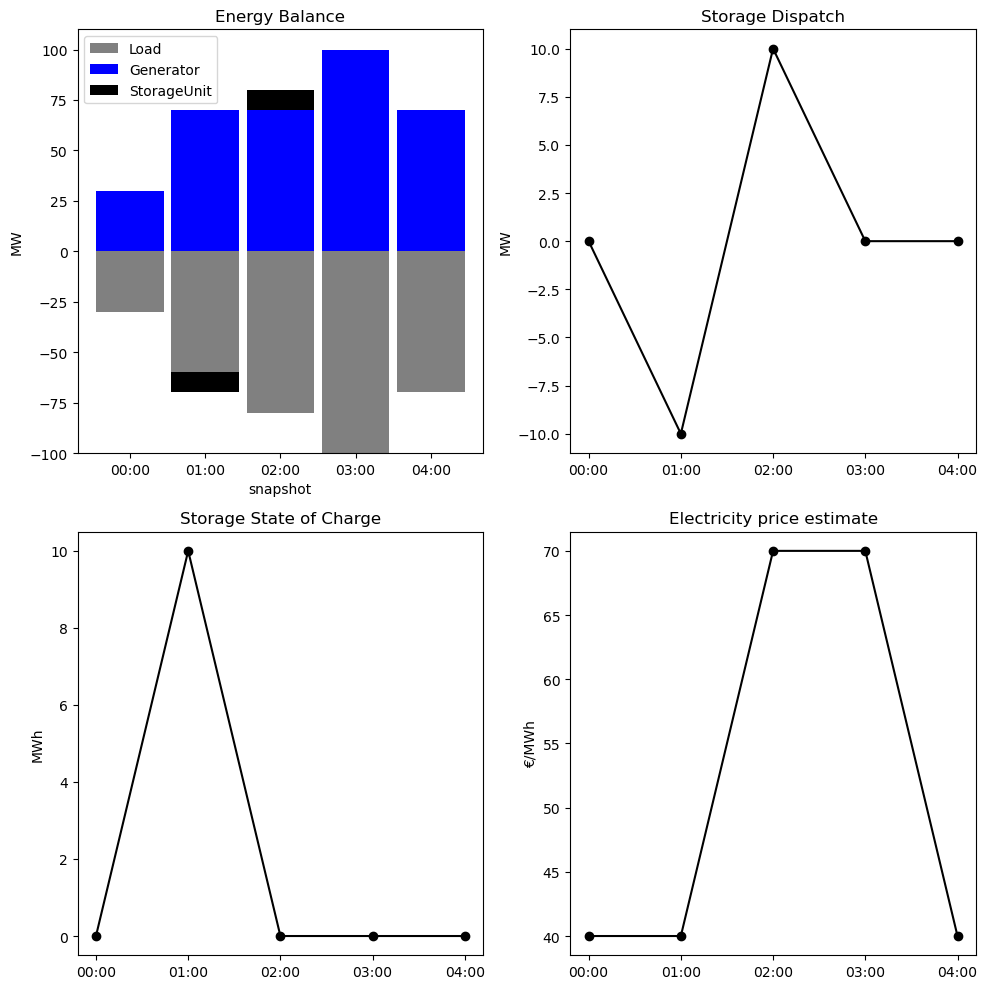

In [208]:
n.optimize(solver_name="gurobi")
dashboard(n)

### FInal Scenario: 20 MW power x 5h duration storage, losses 10% on discharge, 0% on charge

In [230]:
if len(n.storage_units) != 0:
    n.remove("StorageUnit", "Battery")

In [231]:
n.add(
    "StorageUnit",
    "Battery",
    bus="UA",
    p_nom_extendable=False,
    p_nom=20,  # MW
    max_hours=5,  # 100 MW * 10 hours = 1000 MWh
    efficiency_store=1,  # 10% losses
    efficiency_dispatch=0.9,  # no losses
    state_of_charge_initial=0  # MWh
    # cyclic_state_of_charge=True,
)

/home/iegor/miniconda3/envs/pypsa/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/iegor/miniconda3/envs/pypsa/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/iegor/miniconda3/envs/pypsa/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names t

Set parameter TokenServer to value "ensys3.service.tu-berlin.de"


INFO:gurobipy:Set parameter TokenServer to value "ensys3.service.tu-berlin.de"
INFO:linopy.io: Writing time: 0.04s


Read LP format model from file /tmp/linopy-problem-viae1qht.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-viae1qht.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 60 rows, 25 columns, 89 nonzeros


INFO:gurobipy:obj: 60 rows, 25 columns, 89 nonzeros


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)


INFO:gurobipy:Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)


INFO:gurobipy:


CPU model: AMD Ryzen 7 PRO 5850U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 PRO 5850U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 60 rows, 25 columns and 89 nonzeros


INFO:gurobipy:Optimize a model with 60 rows, 25 columns and 89 nonzeros


Model fingerprint: 0x830e085b


INFO:gurobipy:Model fingerprint: 0x830e085b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e+01, 7e+01]


INFO:gurobipy:  Objective range  [4e+01, 7e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+01, 1e+02]


INFO:gurobipy:  RHS range        [2e+01, 1e+02]


Presolve removed 52 rows and 5 columns


INFO:gurobipy:Presolve removed 52 rows and 5 columns


Presolve time: 0.00s


INFO:gurobipy:Presolve time: 0.00s


Presolved: 8 rows, 20 columns, 30 nonzeros


INFO:gurobipy:Presolved: 8 rows, 20 columns, 30 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    5.0995600e+03   5.278053e+01   0.000000e+00      0s


INFO:gurobipy:       0    5.0995600e+03   5.278053e+01   0.000000e+00      0s


      11    1.4110000e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    1.4110000e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.01 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.01 seconds (0.00 work units)


Optimal objective  1.411000000e+04


INFO:gurobipy:Optimal objective  1.411000000e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 25 primals, 60 duals
Objective: 1.41e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, ca

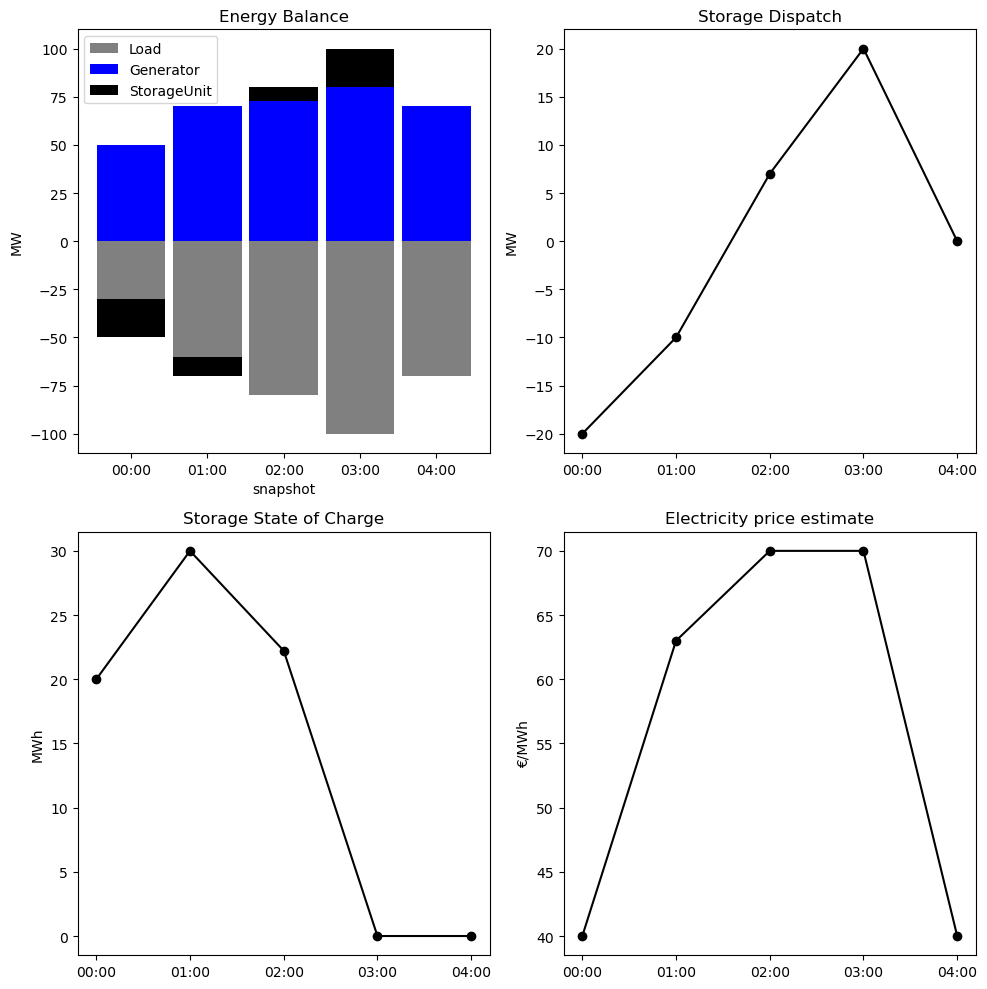

In [232]:
n.optimize(solver_name="gurobi")
dashboard(n)

### Explain --- Why price in hour 01:00 is exactly 63 EUR/MWh?

In [257]:
n.model.dual["Bus-nodal_balance"].values

array([[40.],
       [63.],
       [70.],
       [70.],
       [40.]])

In [258]:
# Hints:
# n.model.dual['StorageUnit-fix-p_dispatch-upper']
# n.model.dual['StorageUnit-fix-p_store-upper']
# n.model.dual['StorageUnit-fix-state_of_charge-upper']
# n.model.dual["Bus-nodal_balance"]